#Load DataSet

**`unzip`**

In [ ]:
! unzip '/content/drive/MyDrive/AIC/TP/Project AI Face Mask Detection/dataset.zip' -d /content/sample_data/data

Archive:  /content/drive/MyDrive/AIC/TP/Project AI Face Mask Detection/dataset.zip
   creating: /content/sample_data/data/dataset/
   creating: /content/sample_data/data/dataset/without_mask/
  inflating: /content/sample_data/data/dataset/without_mask/0.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0014.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0029.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0043.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0074.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0084.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_aidai_0136.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_anhu_0004.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_anhu_0020.jpg  
  inflating: /content/sample_data/data/dataset/without_mask/0_0_anhu_0025.jpg  
  inflating: /

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import the necessary packegs

In [ ]:
# import the necessary packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator ##Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

#Preparing the Data

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4  #initial learning_rate
EPOCHS = 10
BS = 32

In [ ]:
DIRECTORY = '/content/sample_data/data/dataset'
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
print(len(CATEGORIES))

2


In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
IMG_SHAPE = (224, 224, 3)

#Model Creation

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(input_shape=IMG_SHAPE, weights="imagenet", include_top=False,
	input_tensor=Input(shape=IMG_SHAPE)) #Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

In [ ]:
baseModel.summary()

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense( len(CATEGORIES) , activation="softmax")(headModel) #2 Categorie

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

#Data Augmentation

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

Freezing the model

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

#Compiling the Model

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/10
95/95 [==============================] - 33s 348ms/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0395 - val_accuracy: 0.9883
Epoch 2/10
95/95 [==============================] - 33s 348ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0394 - val_accuracy: 0.9896
Epoch 3/10
95/95 [==============================] - 33s 351ms/step - loss: 0.0294 - accuracy: 0.9918 - val_loss: 0.0387 - val_accuracy: 0.9896
Epoch 4/10
95/95 [==============================] - 34s 359ms/step - loss: 0.0306 - accuracy: 0.9921 - val_loss: 0.0335 - val_accuracy: 0.9896
Epoch 5/10
95/95 [==============================] - 35s 372ms/step - loss: 0.0320 - accuracy: 0.9914 - val_loss: 0.0305 - val_accuracy: 0.9922
Epoch 6/10
95/95 [==============================] - 33s 348ms/step - loss: 0.0324 - accuracy: 0.9895 - val_loss: 0.0337 - val_accuracy: 0.9883
Epoch 7/10
95/95 [==============================] - 33s 352ms/step - loss: 0.0288 - accuracy: 0.9918 - val_loss: 0.031

#Evaluate the model

In [ ]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
24/24 [==============================] - 2s 62ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



#Save model

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/AIC/TP/Project AI Face Mask Detection/Model/mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


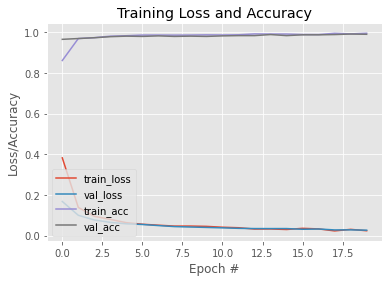

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/AIC/TP/Project AI Face Mask Detection/Model/plot.png")